In [28]:
import cv2
import zipfile
import numpy as np
 
# Read face image from zip file on the fly
faces = {}
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)


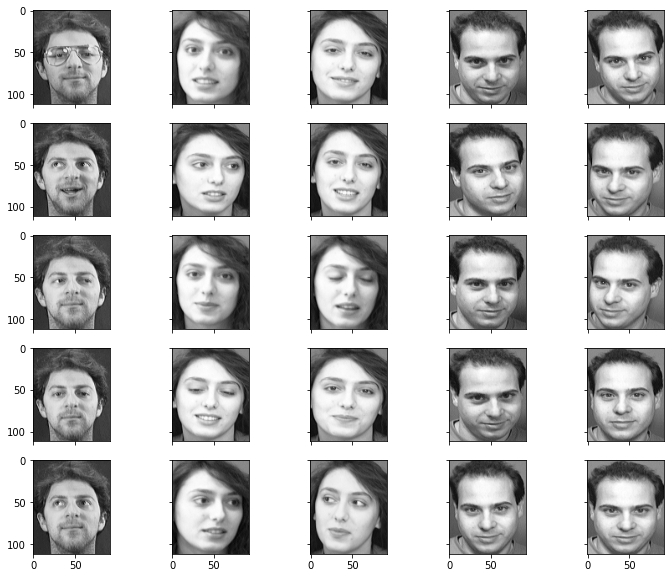

In [29]:
import matplotlib.pyplot as plt
 
fig, axes = plt.subplots(5,5,sharex=True,sharey=True,figsize=(12,10))
faceimages = list(faces.values())[-25:] # take last 25 images
for i in range(25):
    axes[i%5][i//5].imshow(faceimages[i], cmap="gray")
plt.show()

In [30]:
# find pixel size of shape
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

Face image shape: (112, 92)


In [31]:
# We can also find the pixel size of each picture:
print(list(faces.keys())[:5])

['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm']


In [32]:
# and therefore we can put faces of the same person into the same class. There are 40 classes and totally 400 pictures:

classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of pictures:", len(faces))

Number of classes: 40
Number of pictures: 400


In [ ]:
# to illustrate the capability of using eigenface for recognition, we want to hold out some of the pictures before we generate our eigenfaces. We hold out all the pictures of one person as well as one picture for another person as our test set. The remaining pictures are vectorized and converted into a 2D numpy array:
# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if key == "s39/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])
 
# Create facematrix as (n_samples,n_pixels) matrix
facematrix = np.array(facematrix)